In [8]:
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from keras_tuner import Hyperband
import matplotlib.pyplot as plt
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [15]:
def load_all_data(data_files_pattern='data*.npy', label_files_pattern='lab*.npy'):
    data_files = sorted(glob.glob(data_files_pattern))
    label_files = sorted(glob.glob(label_files_pattern))
    X_list, y_list = [], []
    for d_file, l_file in zip(data_files, label_files):
        X_list.append(np.load(d_file))
        y_list.append(np.load(l_file))
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(f"Loaded data shapes: X - {X.shape}, y - {y.shape}")
    return X, y

def preprocess_data(X, y):
    if len(X.shape) == 3:  
        X = np.expand_dims(X, axis=-1)
    X = X.astype('float32') / 255.0 
    y = y.astype('float32')  
    return X, y

def self_attention_block(x, num_heads=4, key_dim=32):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = layers.Add()([x, attn_output]) 
    attn_output = layers.LayerNormalization()(attn_output)
    return attn_output

def build_model(hp):
    input_shape = (40, 168, 1)  
    inputs = layers.Input(shape=input_shape)

    # First convolutional block
    x = layers.Conv2D(hp.Int("filters_1", 32, 128, step=32), kernel_size=hp.Choice("kernel_1", [3, 5]), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Second convolutional block
    x = layers.Conv2D(hp.Int("filters_2", 32, 128, step=32), kernel_size=hp.Choice("kernel_2", [3, 5]), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Third convolutional block
    x = layers.Conv2D(hp.Int("filters_3", 64, 256, step=64), kernel_size=hp.Choice("kernel_3", [3, 5]), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Fourth convolutional block
    x = layers.Conv2D(hp.Int("filters_4", 64, 256, step=64), kernel_size=hp.Choice("kernel_4", [3, 5]), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Fifth convolutional block
    x = layers.Conv2D(hp.Int("filters_5", 128, 512, step=64), kernel_size=hp.Choice("kernel_5", [3, 5]), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Self-attention block
    x = layers.Reshape((1, x.shape[-1]))(x)
    x = self_attention_block(x, num_heads=hp.Int("num_heads", 2, 8, step=2), key_dim=hp.Int("key_dim", 16, 64, step=16))

    # Fully connected layers
    x = layers.Flatten()(x)
    x = layers.Dense(hp.Int("dense_units", 64, 256, step=64), activation='relu')(x)
    x = layers.Dropout(hp.Float("dropout", 0.2, 0.5, step=0.1))(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")), loss=MeanSquaredError(), metrics=["mae"])
    model.summary()
    return model


In [4]:
X, y = load_all_data('data*.npy', 'lab*.npy')
X, y = preprocess_data(X, y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

tuner = Hyperband(build_model,objective="val_loss",max_epochs=20,factor=3,directory="hyp_tuning",project_name="cnn_and_attention")

tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=50, batch_size=32,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

best_model.save('best_cnn_with_attention_model.keras')

Trial 30 Complete [01h 29m 30s]
val_loss: 0.9745143055915833

Best val_loss So Far: 0.7357115149497986
Total elapsed time: 21h 04m 29s
Best Hyperparameters: {'filters_1': 128, 'kernel_1': 5, 'filters_2': 64, 'kernel_2': 3, 'filters_3': 256, 'kernel_3': 5, 'filters_4': 128, 'kernel_4': 3, 'filters_5': 192, 'kernel_5': 3, 'num_heads': 8, 'key_dim': 64, 'dense_units': 192, 'dropout': 0.30000000000000004, 'learning_rate': 0.0010331041248433069, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 40, 168,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 40, 168,   │      3,328 │ input_layer_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 168,   │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 20, 84,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 20, 84,    │     73,792 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 84,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 10, 42,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 10, 42,    │    409,856 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 42,    │      1,024 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 5, 21,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 5, 21,     │    295,040 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 21,     │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 2, 10,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 2, 10,     │    221,376 │ max_pooling2d_7[… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 10,     │        768 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 192)    │          0 │ global_average_p

 Total params: 1,439,041 (5.49 MB)

 Trainable params: 1,437,505 (5.48 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 266s 335ms/step - loss: 36.9560 - mae: 4.4446 - val_loss: 21.5243 - val_mae: 4.1119
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 233s 311ms/step - loss: 7.3948 - mae: 2.1483 - val_loss: 3.7492 - val_mae: 1.5284
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 234s 312ms/step - loss: 5.8716 - mae: 1.8971 - val_loss: 3.7087 - val_mae: 1.5275
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 234s 313ms/step - loss: 5.0553 - mae: 1.7647 - val_loss: 11.5173 - val_mae: 2.9835
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 234s 312ms/step - loss: 4.4059 - mae: 1.6448 - val_loss: 2.8085 - val_mae: 1.2108
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 10771s 14s/step - loss: 4.1206 - mae: 1.6007 - val_loss: 1.6065 - val_mae: 0.9307
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 176s 234ms/step - loss: 3.6783 - mae: 1.5031 - val_loss: 2.7839 - val_mae: 1.3078
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 163s 217ms/step - loss: 3.5102 - mae: 1.4743 - val_loss: 1.8408 - val_mae: 1.0037
Epoch 9/50
750/750 ━━

In [21]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=100, batch_size=32,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

best_model.save('best_cnn_with_attention_model.keras')

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 40, 168,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 40, 168,   │      3,328 │ input_layer_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 168,   │        512 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 20, 84,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 20, 84,    │     73,792 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 84,    │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 10, 42,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 10, 42,    │    409,856 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 42,    │      1,024 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 5, 21,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 5, 21,     │    295,040 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 21,     │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 2, 10,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 2, 10,     │    221,376 │ max_pooling2d_15… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 10,     │        768 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 192)    │          0 │ global_average_p

 Total params: 1,439,041 (5.49 MB)

 Trainable params: 1,437,505 (5.48 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 172s 211ms/step - loss: 38.6630 - mae: 4.4830 - val_loss: 10.9161 - val_mae: 2.7935
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 168s 224ms/step - loss: 6.9120 - mae: 2.0613 - val_loss: 8.7727 - val_mae: 2.5881
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 250s 334ms/step - loss: 5.5903 - mae: 1.8474 - val_loss: 3.4411 - val_mae: 1.4309
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 249s 331ms/step - loss: 4.8101 - mae: 1.7226 - val_loss: 3.7973 - val_mae: 1.5504
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 251s 334ms/step - loss: 4.2769 - mae: 1.6193 - val_loss: 2.2384 - val_mae: 1.1505
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 251s 335ms/step - loss: 4.1108 - mae: 1.5824 - val_loss: 2.4165 - val_mae: 1.2134
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 250s 333ms/step - loss: 3.8273 - mae: 1.5336 - val_loss: 1.2474 - val_mae: 0.7924
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 268s 358ms/step - loss: 3.5175 - mae: 1.4786 - val_loss: 2.2076 - val_mae: 1.1443
Epoch 9/100
75

Text(0, 0.5, 'Loss')

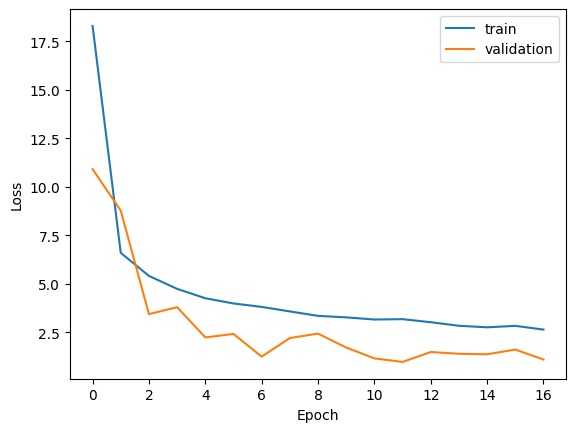

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [29]:
X, y = load_all_data('data*.npy', 'lab*.npy')
X, y = preprocess_data(X, y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
best_model = models.load_model('best_cnn_with_attention_model.keras')
best_model.fit(X_val, y_val, epochs=5, batch_size=32)
y_preds = best_model.predict(X)
best_model.save('best_cnn_with_attention_model_val.keras')

Loaded data shapes: X - (30000, 40, 168), y - (30000,)
Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 90s 362ms/step - loss: 4.1025 - mae: 1.5929
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 57s 304ms/step - loss: 3.1277 - mae: 1.3733
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 63s 334ms/step - loss: 3.1335 - mae: 1.3949
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 67s 356ms/step - loss: 3.1035 - mae: 1.3728
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 66s 351ms/step - loss: 2.7744 - mae: 1.2952
938/938 ━━━━━━━━━━━━━━━━━━━━ 70s 72ms/step
